In [169]:
# Imports for the 
import re
import os
import sqlite3
import matplotlib.pyplot as plt
import pandas as pd
import rdkit
from rdkit.Chem import Descriptors, AllChem
from rdkit.DataManip.Metric import GetTanimotoSimMat
import numpy as np
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from plotnine import *
from plotnine.ggplot import *

In [170]:
if os.path.exists("./MPro_database.db"):
  os.remove("./MPro_database.db")

In [171]:
# Create database file and establish a connection
database_path = "./MPro_database.db"
conn = sqlite3.connect(database_path)
drop_order = ('compounds', 'assays')

In [172]:
# Create a database of compounds and their SMILES string
conn.execute('''
CREATE TABLE compounds
(
    CID PRIMARY KEY,
    SMILES
)
        ''')

In [173]:
df = pd.read_csv('activity_data.csv')

for i in range(len(df)):
    row = df.iloc[i]
    values  =  (row['CID'], 
         row['SMILES']
        )
    conn.execute('INSERT INTO compounds (CID, SMILES) VALUES (?,?)',
        values)

In [174]:
# Creates and populates a table of assays, including a foreign key linking the assays to the compounds table
conn.execute('''
CREATE TABLE assays
(
    CID PRIMARY KEY,
    canonical_CID,
    r_inhibition_at_20_uM,
    r_inhibition_at_50_uM,
    r_avg_IC50,
    f_inhibition_at_20_uM,
    f_inhibition_at_50_uM,
    f_avg_IC50,
    f_avg_pIC50,
    relative_solubility_at_20_uM,
    relative_solubility_at_100_uM,
    trypsin_IC50,
    NMR_std_ratio,
    acrylamide,
    chloroacetamide,
    series,
    frag_id,
    compoundID,
    FOREIGN KEY (CompoundID) REFERENCES compounds (CID)
)
        ''')


In [175]:
df_short = df.iloc[:,1:]

for i in range(len(df_short)):
    row = df_short.iloc[i]
    values = []
    
    for element in row[:]:
        values.append(element)
    values.append(row[0])
    conn.execute('INSERT INTO assays (CID, canonical_CID, r_inhibition_at_20_uM, r_inhibition_at_50_uM, r_avg_IC50, f_inhibition_at_20_uM, f_inhibition_at_50_uM, f_avg_IC50, f_avg_pIC50, relative_solubility_at_20_uM, relative_solubility_at_100_uM, trypsin_IC50, NMR_std_ratio, acrylamide, chloroacetamide, series, frag_id, compoundID) VALUES (?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?)',
             (values)
                )

In [176]:
def retrieve_SMILES(compoundID: str):
    list_smiles = []
    SMILES = conn.execute('''
        SELECT SMILES
        FROM compounds
        WHERE 
            CID = ?
    ''', (compoundID,))
    for sm in SMILES:
        list_smiles.append(sm)
    return (list_smiles[0][0])
        
def retrieve_assays(compoundID: str):
    list_assays = []
    ASSAYS = conn.execute('''
        SELECT *
        FROM assays
        WHERE 
            compoundID = ?
    ''', (compoundID,))
    
    for assay in ASSAYS:
        list_assays.append(assay)
    return (list_assays[0][2:-1])

In [177]:
# Demonstrate we can retrieve the assay data and SMILES string from an ID

print(retrieve_SMILES('MAT-POS-be048f2c-5'))
print(retrieve_assays('MAT-POS-be048f2c-5'))

CCn1nccc1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4ccccc34)C2=O)C1
(None, None, None, None, None, 0.297012069374338, None, None, None, None, None, 0, 0, '3-aminopyridine-like', None)


number of compounds that satisfy all rules: 1525 violate only one: 1950


/home/sabsr3/software_engineering/venv/lib/python3.8/site-packages/plotnine/stats/stat_bin.py:95: PlotnineWarning: 'stat_bin()' using 'bins = 13'. Pick better value with 'binwidth'.


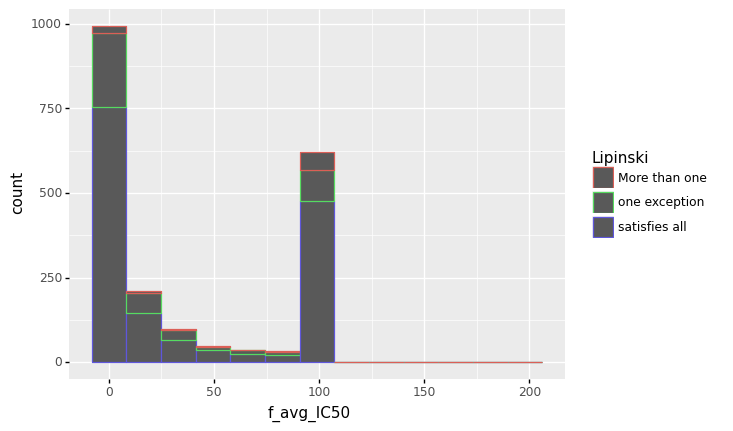

<ggplot: (8792942439370)>

In [259]:
# Limpinski five

list_smiles = []
SMILES = conn.execute('''
    SELECT SMILES 
    FROM compounds
''')

properties = {}
for sm in SMILES:
    list_smiles.append(sm)

for sm in list_smiles:

    m = rdkit.Chem.MolFromSmiles(sm[0])

    HAcceptors = False
    HDonors = False
    MW = False
    LogP = False

    if Descriptors.NumHDonors(m) <= 5:
        HDonors = True
    if Descriptors.NumHAcceptors(m) <= 10:
        HAcceptors = True
    if Descriptors.MolWt(m) < 500:
        MW = True
    if Descriptors.MolLogP(m) < 5:
        LogP = True
    properties[sm[0]] = [HAcceptors,HDonors,MW,LogP]

df_smiles_index = df.set_index('SMILES')
df_properties = pd.DataFrame.from_dict(properties,orient='index', columns=['HAcceptors','HDonors','MW','LogP'])
df_5 = df_properties.loc[df_properties['HAcceptors'] & df_properties['HDonors'] & df_properties['MW'] & df_properties['LogP']]
df_4 = df_properties.loc[(df_properties['HAcceptors'] & df_properties['HDonors'] & df_properties['MW']) |
                        (df_properties['HAcceptors'] & df_properties['HDonors'] & df_properties['LogP']) |
                        (df_properties['HAcceptors'] & df_properties['MW'] & df_properties['LogP']) |
                        (df_properties['HDonors'] & df_properties['MW'] & df_properties['LogP'])]
print('number of compounds that satisfy all rules:', len(df_5), 'violate only one:', len(df_4))
df_smiles_index['Lipinski'] = np.empty(len(df_smiles_index))
df_smiles_index['Lipinski'] = 'More than one'
df_smiles_index.loc[df_4.index,'Lipinski'] = 'one exception'
df_smiles_index.loc[df_5.index,'Lipinski'] = 'satisfies all'


# Dfs only containing assays for the compounds that satisfy all Lipinski
df_5_assays = df_smiles_index.loc[df_5.index].set_index('CID', inplace=True)
# satisfy 3 of the 4
df_4_assays = df_smiles_index.loc[df_4.index]

# 0 in the histogram means there was no data
(ggplot(df_smiles_index.fillna(0), aes(x='f_avg_IC50', color='Lipinski')) + geom_histogram())

In [260]:
descriptor_names = list(rdkit.Chem.rdMolDescriptors.Properties.GetAvailableProperties())
get_descriptors = rdkit.Chem.rdMolDescriptors.Properties(descriptor_names)

def mol_to_descriptors(mol):
    descriptors = []
    if mol:
        descriptors = np.array(get_descriptors.ComputeProperties(mol))
    return descriptors

In [270]:
descriptors_dict = {}

for index, row in df.iterrows():
    id = row['CID']
    smiles_str = retrieve_SMILES(id)
    mol = rdkit.Chem.MolFromSmiles(smiles_str)
    descriptors_dict[id] = np.array(mol_to_descriptors(mol))


{'MAT-POS-be048f2c-5': array([ 4.85161853e+02,  4.85975000e+02,  7.00000000e+00,  0.00000000e+00,
        3.00000000e+00,  0.00000000e+00,  5.00000000e+00,  3.50000000e+01,
        5.90000000e+01,  8.00000000e+00,  2.00000000e+00,  2.59259259e-01,
        6.00000000e+00,  4.00000000e+00,  2.00000000e+00,  1.00000000e+00,
        4.00000000e+00,  2.00000000e+00,  1.00000000e+00,  2.00000000e+00,
        1.00000000e+00,  0.00000000e+00,  1.00000000e+00,  1.00000000e+00,
        2.07472932e+02,  7.13300000e+01,  4.43530000e+00,  1.34484500e+02,
        2.00728448e+01,  1.21416398e+01,  7.52166963e+00,  7.52166963e+00,
        5.76014170e+00,  1.93169159e+01,  1.17636753e+01,  7.28657253e+00,
        7.28657253e+00,  5.58803868e+00, -3.71000000e+00,  2.17986789e+01,
        8.20116443e+00,  3.33249065e+00,  5.10784428e+00]), 'EDJ-MED-cc48ee33-4': array([ 4.85161853e+02,  4.85975000e+02,  7.00000000e+00,  0.00000000e+00,
        2.00000000e+00,  0.00000000e+00,  5.00000000e+00,  3.50000000e

In [272]:
(descriptors_df) = pd.DataFrame(data=descriptors_dict.values(), index = descriptors_dict.keys())



                             0        1    2    3    4    5    6     7     8   \
MAT-POS-be048f2c-5   485.161853  485.975  7.0  0.0  3.0  0.0  5.0  35.0  59.0   
EDJ-MED-cc48ee33-4   485.161853  485.975  7.0  0.0  2.0  0.0  5.0  35.0  59.0   
EDJ-MED-cc48ee33-5   485.161853  485.975  7.0  0.0  2.0  0.0  5.0  35.0  59.0   
MIK-UNK-58cd43d0-1   391.075740  391.880  6.0  2.0  2.0  2.0  4.0  26.0  44.0   
MIK-UNK-78dbf1b8-1   391.075740  391.880  6.0  2.0  2.0  2.0  4.0  26.0  44.0   
...                         ...      ...  ...  ...  ...  ...  ...   ...   ...   
WAR-XCH-eb7b662f-2   272.046489  272.695  5.0  2.0  2.0  2.0  3.0  19.0  28.0   
DAR-DIA-23aa0b97-8   253.096360  253.265  6.0  4.0  2.0  3.0  4.0  19.0  30.0   
DAR-DIA-23aa0b97-11  277.096360  277.287  6.0  3.0  2.0  3.0  3.0  21.0  32.0   
DAR-DIA-23aa0b97-19  287.105862  287.322  4.0  1.0  3.0  1.0  3.0  22.0  35.0   
DAR-DIA-23aa0b97-20  262.110613  262.312  3.0  1.0  3.0  1.0  2.0  20.0  34.0   

                      9   .

In [181]:
# Rdkit has compatibility to save a bit representation of the molecular fingerprint. Here we save the fingerprint array in a dictionary
# and save a list of the bit representations of the fingerprints
fingerprint_dict = {}
fingerprint_bit_list =[]

for index, row in df.iterrows():
    id = row['CID']
    smiles_str = retrieve_SMILES(id)
    mol = rdkit.Chem.MolFromSmiles(smiles_str)
    fingerprint_dict[id] =  AllChem.GetMorganFingerprintAsBitVect(mol,2,nBits=2048)
    fingerprint_bit_list.append(np.array(fingerprint_dict[id]))
    #conn.execute('INSERT INTO compounds (fingerprint) VALUES (?)', (fingerprint,))

In [182]:
# Use the inbuilt dice similarity metric to create a distance matrix between the compounds
num_data = index
sim_matrix_dice = np.zeros((num_data+1, num_data+1))
sim_matrix_tanimoto = np.zeros((num_data+1, num_data+1))
id_list = fingerprint_dict.keys()

for i, i_id in enumerate(id_list):
    for j, j_id in enumerate(id_list):
        sim_matrix_dice[i, j] = rdkit.DataStructs.FingerprintSimilarity(fingerprint_dict[i_id], 
                                fingerprint_dict[j_id], metric=rdkit.DataStructs.DiceSimilarity)
        sim_matrix_tanimoto[i, j] = GetTanimotoSimMat([fingerprint_dict[i_id], 
                                fingerprint_dict[j_id]])[0]


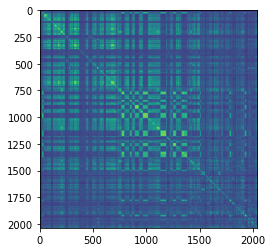

In [183]:
# Output this similarity matrix using the dice metric
fig, ax = plt.subplots()
im = ax.imshow(sim_matrix_dice)

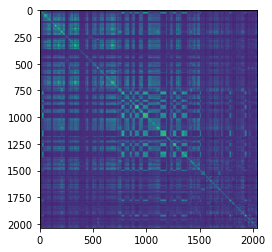

In [184]:
# Output this similarity matrix using tanimoto metric. We see up to a scaling of the similarity matrix the overall pattern is very similar
fig, ax = plt.subplots()
im = ax.imshow(sim_matrix_tanimoto)

(array([ 3.,  6.,  5.,  1.,  6., 29.,  3.,  4.,  2.,  4.,  3., 12.,  5.,
        11., 15., 30.,  6.,  2.,  4.,  5.,  6.,  2.,  8.,  5., 22., 15.,
        12., 10., 37., 14.,  3.,  8.,  7.,  5.,  5., 10.,  5.,  3.,  3.,
         3.,  3.,  4.,  5.,  6.,  6., 10.,  4.,  4.,  2., 15., 10.,  4.,
        19.,  3.,  8., 57., 25., 49.,  5., 17., 18., 12.,  9.,  5.,  3.,
        12., 12.,  8., 31., 18., 21., 22., 11., 11., 34., 12., 32., 11.,
        29., 16., 17.,  8.,  8., 15.,  3.,  8.,  4.,  6., 10., 76., 12.,
         5.,  8.,  4.,  5., 14.,  6.,  8., 14., 13., 14.,  7., 23.,  7.,
        47., 23., 43., 11.,  2.,  5., 19.,  3.,  6.,  3.,  4., 17.,  8.,
         6.,  5.,  3.,  4., 15., 14.,  7.,  3.,  3., 19., 12., 74.,  4.,
        36.,  3.,  2.,  4.,  7., 68.,  4.,  7., 12.,  5.,  3.,  3., 14.,
         4.,  3., 21.,  5.,  4.,  3., 14.,  8., 11.,  5.,  2.,  1.,  1.,
         6.,  5.,  9., 20., 22.,  5.,  9., 26.,  3.,  8.,  8.,  6.,  4.,
         5.,  5.,  8., 46., 15.]),
 array([  0.,   

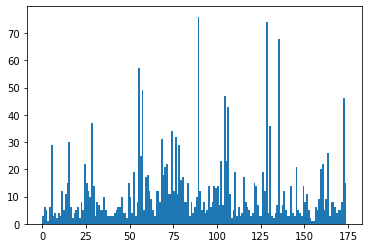

In [185]:
# Using a sklearn clustering method that allows a similarity matrix as input. 
# This algorithmn is slow, but does allow the number of clusters to be undetermined.
cluster = AffinityPropagation(affinity = 'precomputed').fit_predict(sim_matrix_dice)
plt.hist(cluster, bins=max(cluster))

(array([ 3.,  6.,  5.,  1., 29.,  4., 13., 12., 11.,  3.,  4.,  2.,  4.,
         5., 11., 15., 28.,  6.,  4.,  5.,  6.,  2.,  8.,  5., 14., 15.,
        10.,  4., 10., 25., 13.,  3.,  4.,  7.,  6.,  4., 11.,  5.,  3.,
         3.,  3.,  3.,  4.,  2.,  4.,  5.,  5.,  3.,  4.,  6.,  2., 15.,
        10.,  3.,  4.,  5., 27.,  9.,  4.,  3.,  6.,  8.,  4., 14., 26.,
        13., 23.,  5.,  4., 17., 16., 12.,  9.,  3.,  2.,  3., 12.,  4.,
         7.,  6., 26., 17., 14.,  8., 19., 43.,  5.,  8., 12., 16.,  7.,
         8., 12., 12.,  2., 24., 10., 29., 13., 10.,  9.,  8., 15.,  3.,
         8., 12.,  4.,  8.,  7.,  4.,  7.,  9., 35., 12.,  5.,  8.,  5.,
         4.,  5.,  6.,  8., 14., 13., 15., 14.,  3.,  7.,  4.,  4., 15.,
         6.,  8.,  5.,  3., 21.,  7.,  2.,  5., 14.,  7.,  3.,  6.,  3.,
         4.,  2., 14., 11.,  6.,  5., 34.,  3.,  4., 16.,  6.,  5., 10.,
         3.,  3., 19.,  9., 43., 72.,  4., 26.,  3.,  2.,  5., 10.,  7.,
        60.,  4.,  7.,  9.,  7.,  5.,  4.,  3., 12.

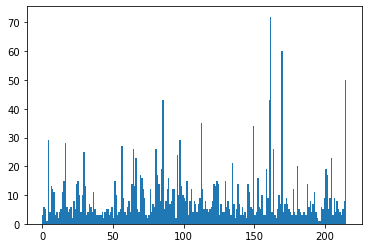

In [186]:
cluster = AffinityPropagation(affinity = 'precomputed').fit_predict(sim_matrix_tanimoto)
plt.hist(cluster, bins=max(cluster))


In [187]:
# There are differences in the clustering due to the two metrics used. However both have clusters limited to about 70 molecules

In [188]:
# Affinity values

conn.execute('''
    ALTER TABLE assays
    ADD pIC50''')

#conn.execute('INSERT INTO compunds (column name) WHERE CID=?', (row[0],))


In [255]:
# The IC50 value common across all molecules is the flourescence averaged.
# This is the sixth assay in the table, so can be extraced from our select_assay function earlier.
# This value is saved in the 

pIC50_list = []
pIC50_dict = {}

for index, row in df.iterrows():
    id = row['CID']
    fIC50 = retrieve_assays(id)[5]
    if not fIC50 is None:
        pIC50 = 6 - np.log10(fIC50)
        pIC50_list.append(pIC50)
        pIC50_dict[id] = [pIC50, min(round(pIC50),2), fingerprint_dict[id]]
    conn.execute('''INSERT INTO assays (pIC50) VALUES (?)''', (pIC50,))
    



In [238]:
short_fingerprint_dict = {}
id = list(pIC50_dict.keys())[0]
print(fingerprint_dict[id])

for i in range(len(fingerprint_dict[id])):
    sum = 0
    for key in pIC50_dict.keys():
        sum += fingerprint_dict[key][i]
    if sum == 0 or sum == len(pIC50_dict.keys()):
        continue
    for key in pIC50_dict.keys():
        if key in short_fingerprint_dict.keys():
            short_fingerprint_dict[key] += [(fingerprint_dict[key][i])]
        else:
            short_fingerprint_dict[key] = [(fingerprint_dict[key][i])]
#print(len(short_fingerprint_dict[id]))

3


(array([673., 199., 202., 221., 220., 193., 154.,  36.,   2.,   1.]),
 array([-2.29666519, -1.80961671, -1.32256822, -0.83551974, -0.34847126,
         0.13857723,  0.62562571,  1.1126742 ,  1.59972268,  2.08677116,
         2.57381965]),
 <BarContainer object of 10 artists>)

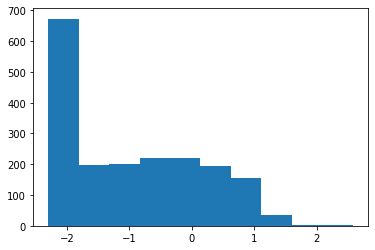

In [190]:
# As we take a logarithm, any scale multiple of ten (ie measuring in moles instead of micro-moles) will shift the x-axis. Therefore the overall shape of the graph
# is the determining factor in the sampling. We see there is an overrepresentation of compounds with a low pIC50, whihc are ones that are less successful binders.
plt.hist(pIC50_list)

In [240]:
## Choosing data to sample
# There are 1901 samples with a flourescent pIC50 value. As pIC50 is dependent on the set-up, we can't compare pIC50 values across 
# Due to the overrepresentation of molecules wth a low binding affinity we want to sample.
# pIC50_dict gives us the molecules, with their pIC50 values
pIC50_df = pd.DataFrame(data=pIC50_dict.values(), index=pIC50_dict.keys(), columns=['pIC50', 'stratified value', 'fingerprint id'])

pIC50_short = pd.DataFrame(data= short_fingerprint_dict.values(), index=pIC50_dict.keys())


In [253]:
# X is a binary bit vector of the fingerprint, y is the float of the pIC50 value
X_train, X_test, y_train, y_test = train_test_split(pIC50_short, pIC50_df['pIC50'], test_size=.1, random_state=0, stratify=pIC50_df['stratified value'])


In [252]:
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)


[ 5.78403138e+10  7.79501915e-01  5.66897392e-01  3.99852620e+10
 -1.66554451e-01  3.06495005e+10  5.00251020e+10 -1.52561299e+10
 -1.64283605e+10 -2.18341923e+00 -2.36153151e+10  3.25771421e+09
 -7.27672126e+10  3.25771421e+09  2.24340502e+10  1.14440788e+11
 -4.54032167e+10  6.08405173e+10 -1.19108677e+00 -3.16090867e+09
  7.36067963e+08  1.07035579e+11  4.58446529e+10  1.97629379e+10
  8.42928647e+10 -2.89887428e-01 -1.63173388e+10  5.66653252e-01
  1.16858196e+00  6.86247826e-01  9.83269312e+09  4.66479301e-01
 -1.79403210e+00 -2.81579599e+10  5.33003807e-01  1.16685991e+11
 -6.06518501e+10 -1.69815773e+10 -1.35394764e+00 -3.86343324e+09
  2.91201591e-01 -1.76927057e+10  3.50909423e+10 -4.45444228e+09
 -3.44134481e+09 -6.31740212e+09 -8.79141864e+10  3.08714584e+10
  2.80546205e+10  9.62061882e-01 -2.39461934e+10  1.65313381e+11
 -2.81546033e+10  3.77572562e+10 -3.04046858e+10  2.03097343e-01
  1.44297600e-01  7.06024342e+10 -4.01907887e+10 -2.31671333e-01
 -9.61338997e-01  6.52855